# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     GridSearchCV)

from sklearn.preprocessing import (StandardScaler, 
                                   PowerTransformer, 
                                   QuantileTransformer)

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC

from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier,
                              StackingClassifier)

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             mean_squared_error, 
                             r2_score)

from lightgbm import LGBMClassifier

# Загрузка данных

In [2]:
df = pd.read_csv("data.csv")

С какой целью был создан набор данных?

Набор данных был создан в рамках научного исследования. Целью было выяснить, 
можно ли заменить дорогостоящую проверку сложных моделей процессов 
(здесь: одновременные многораундовые аукционы, используемые для 
аукционных частотных спектров) прогнозированием результата.

Что представляют собой экземпляры в этом наборе данных?

Каждый экземпляр представляет собой один проверочный запуск. 
Проверка проверяет, возможна ли конкретная цена для конкретного 
продукта и (только для некоторых случаев) может ли конкретный 
участник торгов выиграть продукт по этой цене.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


Variable_Name________Role______Type_____Description__________________________________________Missing Values
process.b1.capacity___Feature___Integer___Capacity (max num of products to win) of Bidder 1.___no
process.b2.capacity___Feature___Integer___Capacity (max num of products to win) of Bidder 2.___no
process.b3.capacity___Feature___Integer___Capacity (max num of products to win) of Bidder 3.___no
process.b4.capacity___Feature___Integer___Capacity (max num of prod to win) of Bidder 4._______no
property.price________Feature___Integer___Price currently verified.____________________________no
property.product______Feature___Integer___Product currently verified.__________________________no
property.winner_______Feature___Integer___Bidder currently verified as winner of the product (0 if only price verified)._no
verification.result_____Target___Categorical_Binary verification result - is the verified outcome possible?_no
verification.time_______Target___Continuous__Runtime of verification procedure.___________________no

# Анализ данных

In [4]:
df.describe()

process.b1.capacity  process.b2.capacity  process.b3.capacity  \
count          2043.000000          2043.000000          2043.000000   
mean              1.000000             2.093979             1.883994   
std               0.816696             0.811269             0.320310   
min               0.000000             0.000000             1.000000   
25%               0.000000             1.000000             2.000000   
50%               1.000000             2.000000             2.000000   
75%               2.000000             3.000000             2.000000   
max               2.000000             3.000000             2.000000   

       process.b4.capacity  property.price  property.product  property.winner  \
count          2043.000000     2043.000000       2043.000000      2043.000000   
mean              0.587861       71.473324          3.252080         0.455213   
std               0.492340        8.048740          1.804225         1.062828   
min               0.000000       59.000000          1.000000         0.000000   
25%               0.000000       65.000000          2.000000         0.000000   
50%               1.000000       70.000000          3.000000         0.000000   
75%               1.000000       78.000000          5.000000         0.000000   
max               1.000000       90.000000          6.000000         4.000000   

       verification.time  
count        2043.000000  
mean         7336.944574  
std         10375.393650  
min            77.916667  
25%           546.818910  
50%          1316.983333  
75%         10876.638889  
max         44130.520833

In [5]:
df.isna().any(axis=1).value_counts()

False    2043
Name: count, dtype: int64

Пустых значений нет, о чем, в принципе, сказано в описании датасета.
Посмотрим распределение фич

In [6]:
columns = df.columns.to_list()
columns

['process.b1.capacity',
 'process.b2.capacity',
 'process.b3.capacity',
 'process.b4.capacity',
 'property.price',
 'property.product',
 'property.winner',
 'verification.result',
 'verification.time']

In [7]:
features = columns[:-2]
target_result = columns[-2]
target_time = columns[-1]

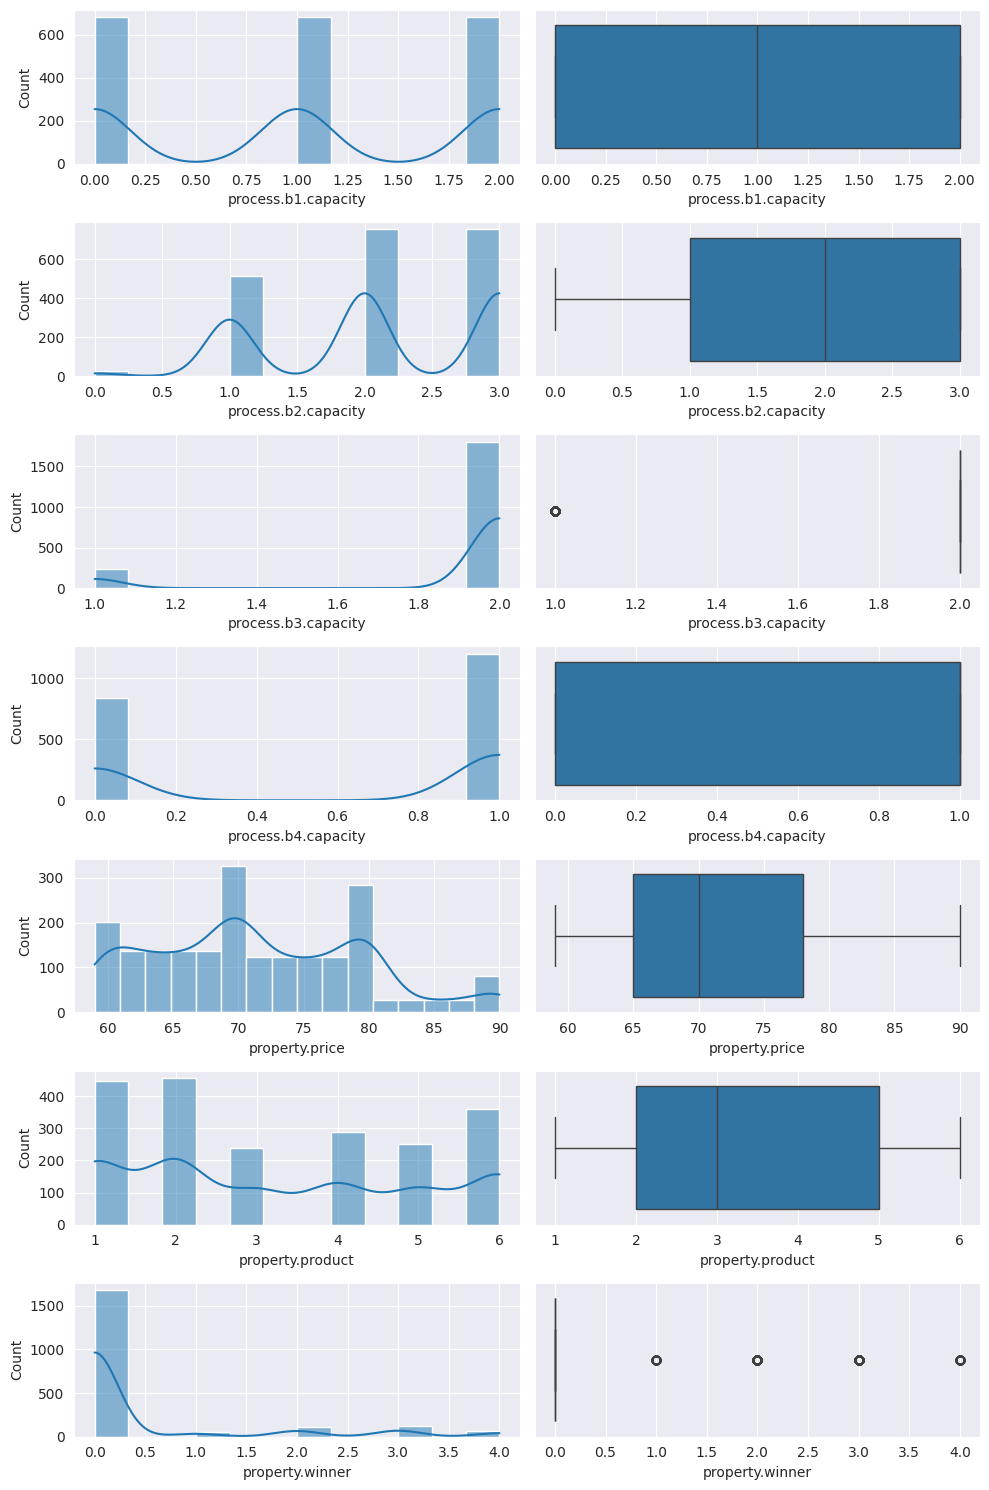

In [8]:
n_rows = len(features)
n_cols = 2
_, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 15))

for idx, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[idx, 0])
    sns.boxplot(data=df, x=feature, ax=axes[idx, 1])
    # axs[row][col].set_title(feature)
    
plt.tight_layout()
plt.show()

Очень нестандартное распределение всех фич. Нужно будет пробовать разные варианты масштабирования

Посмотрим на таргеты

In [9]:
df[target_result].value_counts()

verification.result
False    1781
True      262
Name: count, dtype: int64

In [10]:
df[target_time].describe()

count     2043.000000
mean      7336.944574
std      10375.393650
min         77.916667
25%        546.818910
50%       1316.983333
75%      10876.638889
max      44130.520833
Name: verification.time, dtype: float64

<Axes: title={'center': 'verification.time'}, xlabel='verification.time', ylabel='Count'>

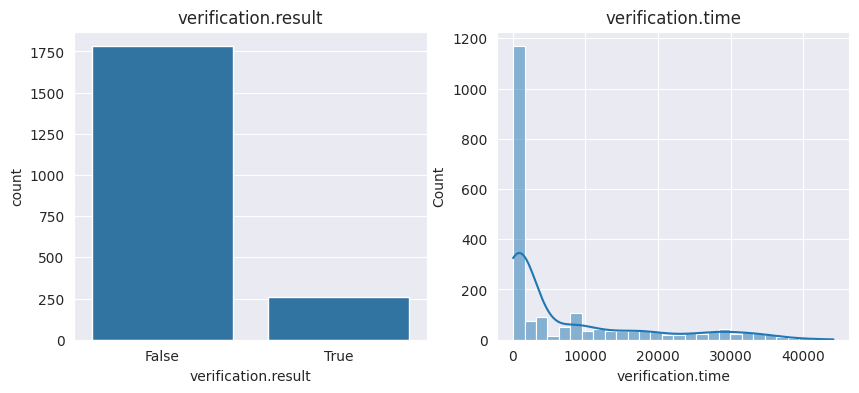

In [11]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title(target_result)
sns.countplot(data=df[target_result].to_frame(), x=target_result, ax=axes[0])
axes[1].set_title(target_time)
sns.histplot(data=df[target_time].to_frame(), x=target_time, kde=True, ax=axes[1])

Датасет не сбалансирован по целевому признаку verification.result.
Необходимо будет пробовать устранение дисбаланса

Что касается verification.time - разброс значений между min и max - 3 порядка
Причем, большинство значений находятся сильно ближе к нижней границе.
Даже не знаю что с таким делать

In [12]:
# Заменим значения в колонке target.result 
# True -> 1 
# False -> 0

df[target_result] = df[target_result].astype("int")

# BAGGING - RandomForest

## RandomForestClassifier

Деревья устойчивы к выбросам и не требуют масштабирования данных.
Но, помним, что целевой класс `verification.result` имеет дисбаланс.
Тем не менее попробуем оценить работу модели сначала на сырых данных,
 а также после применения ресемплера.

In [13]:
X = df[features]
y = df[target_result]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [14]:
model = RandomForestClassifier(random_state=42)

model_cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1))
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"Random forest. CV: {model_cv_score}, test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

Random forest. CV: 0.9713286713286713, test: 0.9804241435562806

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       534
           1       1.00      0.85      0.92        79

    accuracy                           0.98       613
   macro avg       0.99      0.92      0.95       613
weighted avg       0.98      0.98      0.98       613


## RandomForestRegressor

Попоробуем постороить модель для прогнозирования второго таргета - `verification.time`

In [15]:
X = df[features]
y = df[target_time]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
model = RandomForestRegressor(random_state=42)

model_cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5,
                                         scoring="neg_root_mean_squared_error", n_jobs=-1))
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
model_test_score = mean_squared_error(y_true=y_test, y_pred=y_predicted, squared=False)
model_test_r2score = r2_score(y_true=y_test, y_pred=y_predicted)

print(f"Random forest.\nCV RMSE: {model_cv_score}"
      f"\ntest RMSE: {model_test_score}"
      f"\ntest R2: {model_test_r2score}")

Random forest.
CV RMSE: -1266.879589125703
test RMSE: 913.4665751655579
test R2: 0.9916711352336463


Сама по себе цифра 913 выглядит внушительно, но вспомним, что разброс нашего 
таргета от 77 до 44130 со средним 7736, т.е. вроде даже и неплохо. 
При этом коэффициент детерминации 0.99, что является отличным результатом.

Даже закралось сомнение не имеет ли какая-то из фич яркой корреляции с таргетом?
Проверим это построив корреляционную матрицу.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'process.b1.capacity'),
  Text(1.5, 0, 'process.b2.capacity'),
  Text(2.5, 0, 'process.b3.capacity'),
  Text(3.5, 0, 'process.b4.capacity'),
  Text(4.5, 0, 'property.price'),
  Text(5.5, 0, 'property.product'),
  Text(6.5, 0, 'property.winner'),
  Text(7.5, 0, 'verification.time')])

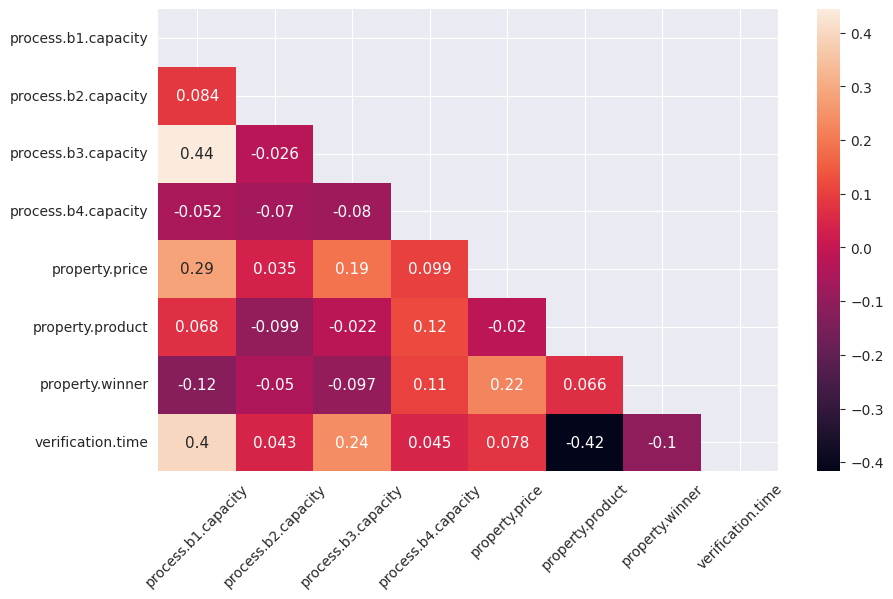

In [17]:
dfс = pd.concat([X, y], axis=1)

corr_matrix = dfс.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"fontsize":11})
plt.xticks(rotation=45)

Нет, корреляций нет. Значит наш RandomForestRegressor построил нам отличную модель.

## SMOTE Tomek -> RandomForestClassifier 

Но вернемся на шаг назад, устраним дисбаланс таргета и попробуем 
обучить классификатор повторно.

In [18]:
X = df[features]
y = df[target_result]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
from imblearn.combine import SMOTETomek
resampler = SMOTETomek(random_state=42)

X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

<Axes: title={'center': 'After resampling'}, xlabel='verification.result', ylabel='count'>

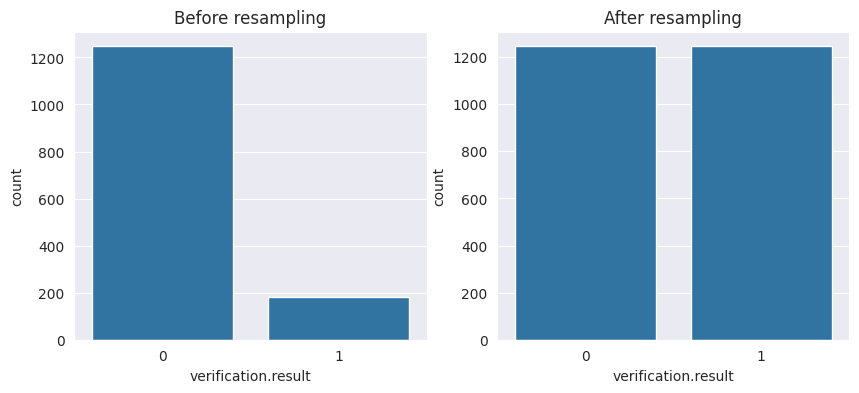

In [20]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title("Before resampling")
sns.countplot(data=y_train.to_frame(), x="verification.result", ax=axes[0])
axes[1].set_title("After resampling")
sns.countplot(data=y_train_resampled.to_frame(), x="verification.result", ax=axes[1])

In [21]:
model = RandomForestClassifier(random_state=42)

model_cv_score = np.mean(cross_val_score(model, X_train_resampled, y_train_resampled, 
                                         cv=5, scoring="accuracy", n_jobs=-1))
model.fit(X_train_resampled, y_train_resampled)
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"SMOTE Tomek + Random forest. CV: {model_cv_score}, test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

SMOTE Tomek + Random forest. CV: 0.9807422073061787, test: 0.9722675367047309

               precision    recall  f1-score   support

           0       0.98      0.98      0.98       534
           1       0.89      0.90      0.89        79

    accuracy                           0.97       613
   macro avg       0.94      0.94      0.94       613
weighted avg       0.97      0.97      0.97       613


Интересный результат. 
На кросс-валидации модель несколько улучшила accuracy
В то же время, на тестовой части стало несколько хуже.

Было: Random forest. CV: 0.9713286713286713, test: 0.9804241435562806
Стало: SMOTE Tomek + Random forest. CV: 0.9807422073061787, test: 0.9722675367047309

Это особенно заметно именно на минорном классе
Было: True       1.00      0.85      0.92        79
Стало: True       0.89      0.90      0.89        79

precision снизился с 1.00 до 0.89, зато повысился recall с 0.85 до 0.9

# BOOSTING - Light GBM

In [22]:
X = df[features]
y = df[target_result]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## default

In [23]:
model = LGBMClassifier(random_state=42)

model_cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1))
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"\nLight GBM. CV: {model_cv_score}, test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

[LightGBM] [Info] Number of positive: 183, number of negative: 1247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1430, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127972 -> initscore=-1.919010
[LightGBM] [Info] Start training from score -1.919010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

## Подбор гиперпараметров

In [27]:
model = LGBMClassifier(random_state=42)

lgbmc_parameters = {
    "num_leaves": range(20, 50),
    "max_depth": range(1, 10),
}

cv_model = GridSearchCV(model, param_grid= lgbmc_parameters, cv=5, scoring="accuracy")
cv_model.fit(X_train, y_train)

model = cv_model.best_estimator_
model

[LightGBM] [Info] Number of positive: 147, number of negative: 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1144, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128497 -> initscore=-1.914318
[LightGBM] [Info] Start training from score -1.914318
[LightGBM] [Info] Number of positive: 147, number of negative: 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 1144, number of used features: 7
[LightGBM] [Info] [binary:BoostFro

LGBMClassifier(max_depth=9, num_leaves=22, random_state=42)

In [28]:
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"Light GBM after GSCV Test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

Light GBM after GSCV Test: 0.9934747145187602

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       534
           1       1.00      0.95      0.97        79

    accuracy                           0.99       613
   macro avg       1.00      0.97      0.99       613
weighted avg       0.99      0.99      0.99       613


Прекрасно - наша модель повторила свой собственный результат ))

default___________0.9934747145187602
GridSearchCV____0.9934747145187602

# STACKING - StackingClassifier

In [29]:
X = df[features]
y = df[target_result]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## default

In [30]:
svc_pipe = Pipeline([("scaler", StandardScaler()), ("model", LinearSVC(dual="auto", random_state=42))])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier(n_jobs=-1))])

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)),
    ('svc', svc_pipe),
    ("knn", knn_pipe),
]

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)

model_cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1))
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"Stacking classifier. CV: {model_cv_score}, test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

Stacking classifier. CV: 0.9615384615384617, test: 0.9722675367047309

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       534
           1       0.94      0.84      0.89        79

    accuracy                           0.97       613
   macro avg       0.96      0.91      0.94       613
weighted avg       0.97      0.97      0.97       613


## Подбор гиперпараметров

In [31]:
model_parameters = {
    "rf__n_estimators": [10, 20, 30, 40, 50],
    "svc__model__C": [1, 10],    
    "knn__model__n_neighbors": [3, 5, 7, 9],
    "knn__model__weights": ["uniform", "distance"],
}

cv_model = GridSearchCV(model, param_grid= model_parameters, cv=5, scoring="accuracy", n_jobs=-1)
cv_model.fit(X_train, y_train)

model = cv_model.best_estimator_
model

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=40,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 LinearSVC(C=1, dual='auto',
                                                           random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=3,
                                                                      weights='distance'))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [32]:
y_predicted = model.predict(X_test)
model_test_score = accuracy_score(y_true=y_test, y_pred=y_predicted)

print(f"Stacking classifier after GSCV Test: {model_test_score}")
print("\n", classification_report(y_true=y_test, y_pred=y_predicted))

Stacking classifier after GSCV Test: 0.9869494290375204

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       534
           1       0.99      0.91      0.95        79

    accuracy                           0.99       613
   macro avg       0.99      0.95      0.97       613
weighted avg       0.99      0.99      0.99       613


После подбора гиперпараметров модель улучшила свои показатели

# Резюме
Самые высокие показатели продемонстрировала модель Light GBM.
Тем не менее все модели отлично отработали -  
отставание от лидера после подбора гиперпараметров в сотых долях. 